In [1]:
import tensorflow as tf

In [2]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.8.0


In [3]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2025-03-28 13:36:43.582537


In [4]:
# Get helper functions file
import os

if os.path.exists("helper_functions.py"):
    print("[INFO] 'helper_functions.py' already exists, skipping download.")
else:
    print("[WARNING] 'helper_functions.py' not found. Please add it to the directory.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [6]:
# Get tensorflow dataset
import tensorflow_datasets as tfds

In [7]:
# Get all available datsets in TFDS
dataset_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in dataset_list}")

'food101' in TensorFlow Datasets: True


In [8]:
# Load in the dta 
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get?
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format
                                             with_info=True) # include dataset metadata?

In [9]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Take one sample off the training data
train_one_sample = train_data.take(1)

In [12]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
        Image shape: {image.shape}
        Image dtype: {image.dtype}
        Target class from Food101 (tensor form): {label}
        Class name (str form): {class_names[label.numpy()]}
        """)


        Image shape: (512, 512, 3)
        Image dtype: <dtype: 'uint8'>
        Target class from Food101 (tensor form): 72
        Class name (str form): pancakes
        


In [16]:
# What does an image tensor from tfds food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 42,  40,  51],
        [ 41,  39,  50],
        [ 40,  38,  49],
        ...,
        [ 50,  23,   6],
        [ 51,  24,   7],
        [ 51,  24,   7]],

       [[ 41,  39,  50],
        [ 41,  39,  50],
        [ 41,  39,  50],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 49,  22,   5]],

       [[ 40,  38,  49],
        [ 41,  39,  50],
        [ 42,  40,  51],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 48,  21,   4]],

       ...,

       [[188, 180, 191],
        [188, 180, 191],
        [189, 181, 192],
        ...,
        [179, 178, 186],
        [177, 176, 184],
        [175, 174, 182]],

       [[185, 177, 188],
        [186, 178, 189],
        [187, 179, 190],
        ...,
        [178, 177, 185],
        [176, 175, 183],
        [175, 174, 182]],

       [[179, 171, 182],
        [181, 173, 184],
        [183, 175, 186],
        ...,
        [177, 176, 18

In [17]:
# what are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

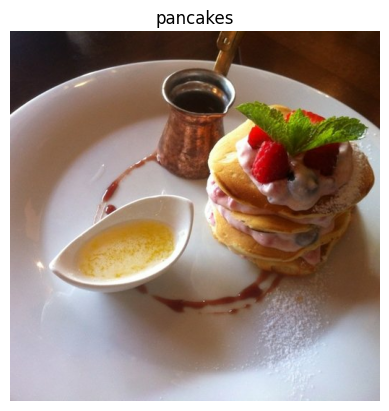

In [18]:
# Plot an image tensor
import matplotlib.pyplot as plt 
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [19]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [20]:
# Preprocess a single sample image and check the output
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[42 40 51]
  [41 39 50]
  [40 38 49]
  ...
  [50 23  6]
  [51 24  7]
  [51 24  7]]

 [[41 39 50]
  [41 39 50]
  [41 39 50]
  ...
  [47 20  3]
  [48 21  4]
  [49 22  5]]]...,
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[41.127552  39.127552  50.127552 ]
  [40.642857  38.642857  49.642857 ]
  [40.285713  38.285713  49.285713 ]
  ...
  [48.92855   21.928549   4.500022 ]
  [47.7398    20.7398     3.7398005]
  [49.301044  22.301043   5.3010426]]

 [[40.642857  38.642857  49.642857 ]
  [42.9949    40.9949    51.9949   ]
  [41.85714   39.85714   50.85714  ]
  ...
  [49.127533  22.127531   4.699003 ]
  [47.862247  20.862246   3.8622465]
  [48.928574  21.928572   4.9285717]]]...,
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


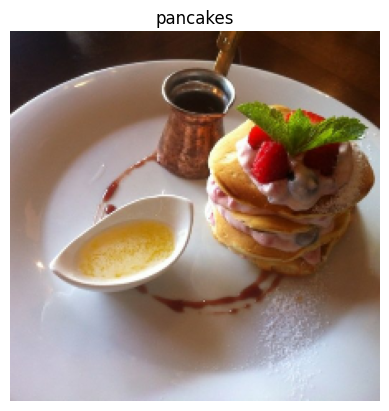

In [21]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capability)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [22]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [23]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [24]:
# Create TensorBoard callback 
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints.weights.h5" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights 
                                                      verbose=0) # do not print out whether or not model is being saved

In [25]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [26]:
mixed_precision.global_policy() # should output 'mixed_float16'

<Policy "mixed_float16">

In [27]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [28]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [29]:
# Check the dtye_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers
    

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [30]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [31]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Should return True
print(tf.config.list_physical_devices('GPU'))  # Should list your GPU

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

history_101_food_classes_feature_extract = model.fit(train_data,
                                                         epochs=3,
                                                         steps_per_epoch=len(train_data),
                                                         validation_data=test_data,
                                                         validation_steps=int(0.15 * len(test_data)),
                                                         callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_101_classes_all_data_feature_extract"), model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20250328-133801
Epoch 1/3
2368/2368 [==============================] - 368s 150ms/step - loss: 1.8225 - accuracy: 0.5581 - val_loss: 1.2390 - val_accuracy: 0.6732
Epoch 2/3
2368/2368 [==============================] - 356s 150ms/step - loss: 1.2939 - accuracy: 0.6670 - val_loss: 1.1250 - val_accuracy: 0.6962
Epoch 3/3
2368/2368 [==============================] - 357s 151ms/step - loss: 1.1424 - accuracy: 0.7024 - val_loss: 1.0922 - val_accuracy: 0.7039


In [33]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 109s 137ms/step - loss: 1.0938 - accuracy: 0.7054


[1.0938223600387573, 0.7054257392883301]

In [34]:
# 1. Create a function to recreate the original model
def create_model():
    # Create base model
    input_shape = (224, 224, 3)
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
    base_model.trainable = False # freeze base model layers
    
    # Create Functional model
    inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
    # Note: EfficientNetBX models have rescaling built-in but if your model did not you could have a layer like below
    #x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = base_model(inputs, training=False) # set base_model to inference mode only
    x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
    x = tf.keras.layers.Dense(len(class_names))(x) # want one output neuron per class
    # Separate activation of output layer so we can output float32 activations
    outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)


790/790 [==============================] - 110s 137ms/step - loss: 1.0938 - accuracy: 0.7054


In [35]:
# 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close

In [36]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False

In [37]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [38]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [39]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [40]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 113s 141ms/step - loss: 1.0938 - accuracy: 0.7054


[1.093821406364441, 0.7054257392883301]

In [41]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

In [43]:
# Load and evaluate our model
loaded_gs_model = tf.keras.models.load_model("07_efficientnetb0_feature_extract_model_mixed_precision")

In [44]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [45]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 109s 137ms/step - loss: 1.0938 - accuracy: 0.7054


[1.0938225984573364, 0.7054257392883301]

In [46]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [47]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

In [48]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [49]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [50]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [51]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20250328-141107
Epoch 1/100
2368/2368 [==============================] - 681s 283ms/step - loss: 0.9235 - accuracy: 0.7526 - val_loss: 0.8090 - val_accuracy: 0.7744 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 674s 285ms/step - loss: 0.5790 - accuracy: 0.8398 - val_loss: 0.7697 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 647s 273ms/step - loss: 0.3307 - accuracy: 0.9063 - val_loss: 0.8475 - val_accuracy: 0.7847 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9491
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 645s 272ms/step - loss: 0.1731 - accuracy: 0.9491 - val_loss: 0.9444 - val_accuracy: 0.7797 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 645s 27

In [52]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [ ]:
# Load in fine-tuned model
loaded_fine_tuned_gs_model = tf.keras.models.load_model("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [54]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [55]:
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 111s 139ms/step - loss: 1.0253 - accuracy: 0.7983


[1.0253159999847412, 0.7982970476150513]